In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch 
import torch.nn as nn
import yfinance as yf
import keras 
import tensorflow
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input


# sp500list = pd.read_csv("SP500.csv")
# ListOfTickers = []
# for i in sp500list['Symbol']:
#     ListOfTickers.append(i)


# ListOfTickers.remove('BRK.B')
# ListOfTickers.remove('BF.B')
# ListOfTickers.remove('GEV')
# ListOfTickers.remove('SOLV')
# ListOfTickers.remove('HUBB')
#ListOfTickers.remove('AGN')
#ListOfTickers.remove('AGN')
ListOfTickers = ['aapl','goog','meta','msft','amzn','tsla','nvda']
print(ListOfTickers)

def TickerIntoTensor(ticker='aapl',daysago=100,split_percentage=0.9):
    df = yf.Ticker(ticker.upper())
    df = df.history(period='max')
    if df.shape[1] == 7:
        df = df.drop(columns=['Dividends','Stock Splits'])
    df = df.drop(columns=['Open','High','Low','Volume'])
    for i in range(daysago,-2,-1):
        df['{}daysago'.format(i)] = df['Close'].shift(i)
        df = df.copy()
    df = df.drop(columns=['Close'])
    df = df.drop(index=df.tail(1).index)
    df = df.drop(index=df.head(daysago).index)
    sc = MinMaxScaler(feature_range=(0,1))
    df_scaled = sc.fit_transform(df)
    X,Y = df_scaled[:,:daysago+1],df_scaled[:,-1]
    split = int(len(X)*split_percentage)
    X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
    X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1)), Y_train.reshape((-1,1)), Y_test.reshape((-1,1))
    #X_train, X_test, Y_train, Y_test = torch.tensor(X_train).float(), torch.tensor(X_test).float(), torch.tensor(Y_train).float(), torch.tensor(Y_test).float()
    return X_train, X_test, Y_train, Y_test

sp500 = TickerIntoTensor('^gspc')
sp500_X_train = sp500[0]
sp500_X_test = sp500[1]
sp500_Y_train = sp500[2]
sp500_Y_test = sp500[3]


['aapl', 'goog', 'meta', 'msft', 'amzn', 'tsla', 'nvda']


In [4]:
lstm_input = Input(shape=(101, 1), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')

ListOfTickers = ['aapl']
for ticker in ListOfTickers:
    e= TickerIntoTensor(ticker)
    X_train= e[0]
    sp500_X_test = np.concatenate((sp500_X_test,e[1]))
    Y_train= e[2]
    sp500_Y_test = np.concatenate((sp500_Y_test,e[3]))
    
    print(ticker)
    model.fit(x=X_train, y=Y_train, batch_size=128, epochs=2, shuffle=True, validation_split = 0.1)

X_test = sp500_X_test
Y_test = sp500_Y_test

aapl
Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 1.6402e-04 - val_loss: 3.9264e-05
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 1.2647e-06 - val_loss: 3.8736e-05
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 1.2606e-06 - val_loss: 4.0061e-05
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 1.2596e-06 - val_loss: 3.7270e-05
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 1.1675e-06 - val_loss: 3.6404e-05
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 1.3376e-06 - val_loss: 3.5554e-05
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 1.3295e-06 - val_loss: 4.7588e-05
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - loss: 1.3229e-06 - val_loss: 3.4652e-05
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - loss: 1.2221e-06 - val_loss: 3.4927e-05
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 1.2515e-06 - val_loss: 3.3947e-05


In [5]:
y_pred = model.predict(X_test)
avg_error = (np.sum(np.sqrt((Y_test - y_pred)**2)))/len(Y_test)*100
print(avg_error)
avg_error = (np.sum(y_pred - Y_test))/len(Y_test)*100
print(avg_error)

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
1.6736034892177767
-1.3428129198292111


<Axes: >

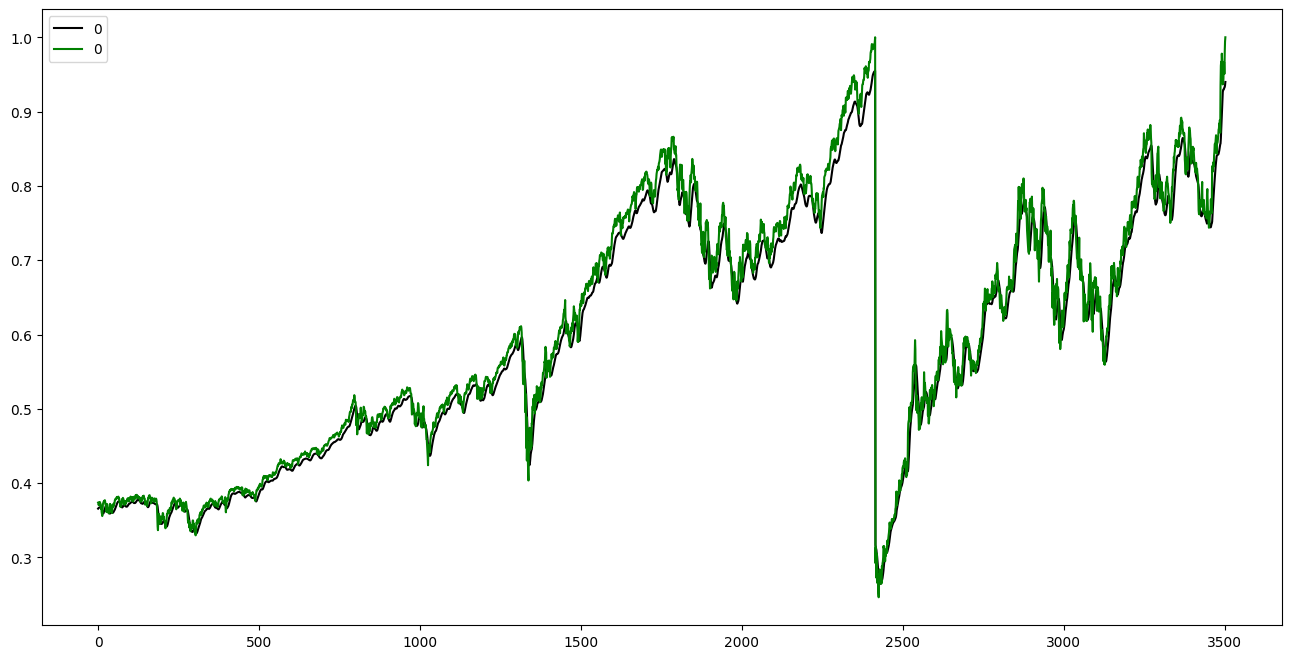

In [6]:
q,w = pd.DataFrame(y_pred),pd.DataFrame(Y_test)
e = pd.concat([q,w],axis=1)
e.plot(figsize=(16,8),color = ('black','green'))

In [7]:
def UserInput_Shit(ticker='aapl',daysago=100):
    df = yf.Ticker(ticker.upper())
    df = df.history(period='max',end='2023-01-01')
    if df.shape[1] == 7:
        df = df.drop(columns=['Dividends','Stock Splits'])
    df = df.drop(columns=['Open','High','Low','Volume'])
    for i in range(daysago,-2,-1):
        df['{}daysago'.format(i)] = df['Close'].shift(i)
        df = df.copy()
    df = df.drop(columns=['Close'])
    df = df.drop(index=df.tail(1).index)
    df = df.drop(index=df.head(daysago).index)
    sc = MinMaxScaler(feature_range=(0,1))
    df_scaled = sc.fit_transform(df)
    X,Y = df_scaled[:,:daysago+1],df_scaled[:,-1]
    X_train, X_test, Y_train, Y_test = X[:-1], X[-1:], Y[:-1], Y[-1:]
    X_train, X_test, Y_train, Y_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1)), Y_train.reshape((-1,1)), Y_test.reshape((-1,1))
    #X_train, X_test, Y_train, Y_test = torch.tensor(X_train).float(), torch.tensor(X_test).float(), torch.tensor(Y_train).float(), torch.tensor(Y_test).float()
    return X_train, X_test, Y_train, Y_test

X_test = UserInput_Shit()[1]

In [8]:

def UserInput_Two(ticker='aapl',daysago=100,futureproj=20):
    X_test = UserInput_Shit(ticker,daysago)[1]
    y_pred_proj = []
    for i in range(1,futureproj+1):
        y_pred = model.predict(X_test)
        y_pred_proj = np.append(y_pred_proj,y_pred)
        X_test = X_test.reshape((-1))
        X_test = np.append(X_test, y_pred)
        #X_test = X_test[1:]
        X_test = X_test.reshape((-1,daysago+1+i,1))
    return y_pred_proj 

UserInput_Two()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([0.70202786, 0.69647735, 0.69108093, 0.68580735, 0.68063861,
       0.67556208, 0.67056805, 0.66565084, 0.66080415, 0.65602487,
       0.65130997, 0.64665687, 0.64206368, 0.6375283 , 0.63304913,
       0.62862504, 0.62425494, 0.61993736, 0.61567128, 0.61145568])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

<Axes: >

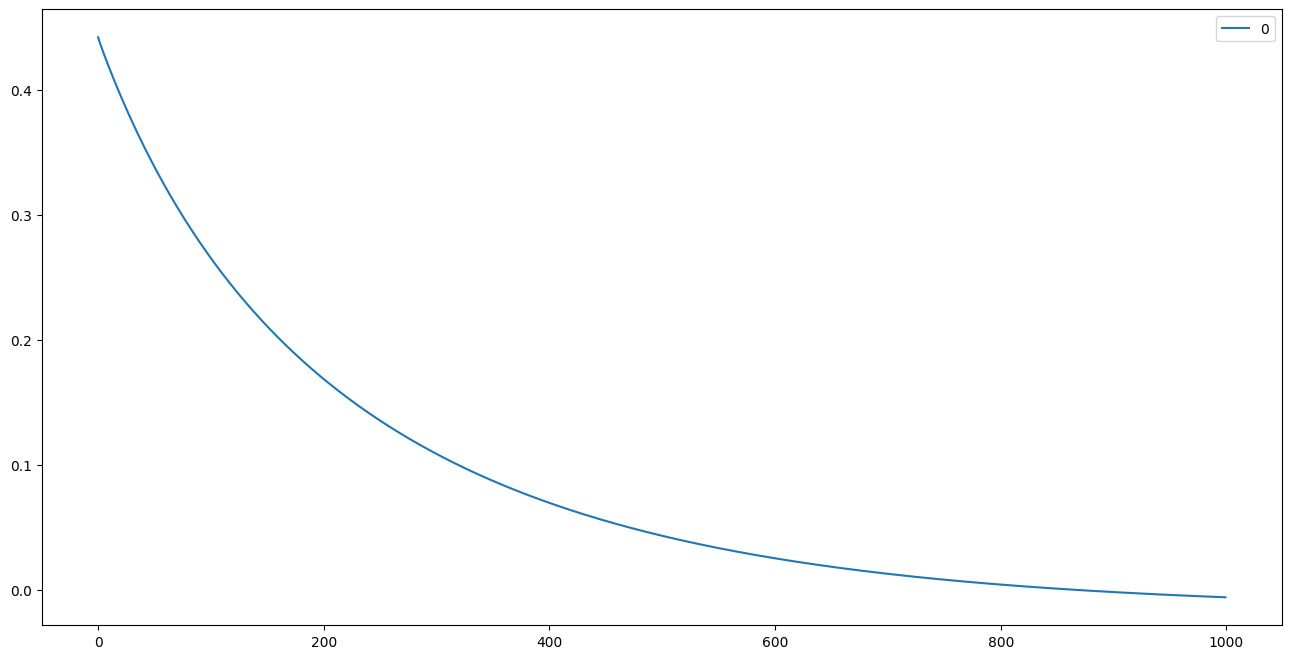

In [9]:
e = pd.DataFrame(UserInput_Two('amzn',50,1000))
e.plot(figsize=(16,8))